# Eigenvalue bounds estimation for the Laplacian by using the finite element method

<em>Last updated by Xuefeng LIU, August 7, 2024</em>

We consider two domains: (Part I) the unit square domain and (Part II) the L-shaped domain.

## Part I:

On a square domain $\Omega$, consider the following eigenvalue problem

$$
-\Delta u = \lambda u \mbox{ in } \Omega, u=0 \mbox{ on } \partial \Omega \:.
$$

The variational formulation for the above eigenvalue problem is to find $u\in H_0^1(\Omega)$ and $\lambda \in R$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v dx = \lambda \int_{\Omega} uvdx \mbox{ for all }  v \in H_0^1(\Omega) \:.
$$

Below, we show how to solve the eigenvalue problem step by step.

Particular, in this speical case, the first 9 eigenvalue are given by 
$$
\left\{\frac{\lambda_i}{\pi^2} \right\}_{i=1}^{9}  = \{2,5,5,8,10,10,13,13,17\} \:.
$$

### Objective:
    
Calculate the lower and upper bounds for the leading 9 exact eigenvalues.

A lower bound for the $k$ eigenvalue is given by [Liu-Oishi,SINM'2013]:
$$
\lambda_k \ge \frac{\lambda_{k,h}}{1+(0.0.493h)^2 \lambda_{k,h}} , \quad (k=1,\cdots, \text{dim}(V_h))
$$
Here, $h$ is the largest median edge length over all triangular elements.

**Note** This result works only for convex poygonal domains.


## Step 1 : Mesh generation and FEM space definition

In [103]:
from dolfin import *

N=32; h=1.0/N
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, "CG", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)

## Step 2: Variational formulation

In [104]:
# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)

# set the diagonal elements of B corresponding to boundary nodes to zero to
# remove spurious eigenvalues.
bc.zero(B)

## Step 3: Calculate matrix and solve the matrix eigenvalue problem

In [105]:
def scipy_get_leading_eigenvalues(MatA, MatB, nreq, msg=True):
    
    import numpy as np
    from scipy.sparse.linalg import eigsh
    import scipy.sparse as sp
    
    row_,col_,val_ = MatA.mat().getValuesCSR()
    sA = sp.csr_matrix((val_,col_,row_))
    row_,col_,val_ = MatB.mat().getValuesCSR()
    sB = sp.csr_matrix((val_,col_,row_))
    
    #Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html
    #Since the "LM" calculation is more stable,we first fetch the largest eigenvalues of Mx=lambda Ax and then take the reverse.
    reverse_eigenvalues, reverse_eigenvectors = eigsh(sB,k=nreq, M=sA,which="LM", return_eigenvectors=True, mode="normal")
    eigenvalues = 1./reverse_eigenvalues
    eigenvalues.sort()
    return eigenvalues, np.flip(reverse_eigenvectors,1)


In [106]:
# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

eigenvalues, eigenvectors = scipy_get_leading_eigenvalues(MatA, MatB, 9)

## Step 4: Extract the eigenvalue and eigenfunction 

In [108]:
import numpy as np

exact_eigvalues = np.array([2,5,5,8,10,10,13,13,17])*pi**2;

# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(0,9):
    eig_value = eigenvalues[k]
    exact_eig = exact_eigvalues[k]    
    print("The %dth approximate eigenvalue:%8.3f*pi^2 (exact one:%4d*pi^2)"%(k+1, eig_value/(pi**2), np.rint(exact_eig/(pi**2))))

The 1th approximate eigenvalue:   2.005*pi^2 (exact one:   2*pi^2)
The 2th approximate eigenvalue:   5.021*pi^2 (exact one:   5*pi^2)
The 3th approximate eigenvalue:   5.032*pi^2 (exact one:   5*pi^2)
The 4th approximate eigenvalue:   8.077*pi^2 (exact one:   8*pi^2)
The 5th approximate eigenvalue:  10.095*pi^2 (exact one:  10*pi^2)
The 6th approximate eigenvalue:  10.095*pi^2 (exact one:  10*pi^2)
The 7th approximate eigenvalue:  13.144*pi^2 (exact one:  13*pi^2)
The 8th approximate eigenvalue:  13.243*pi^2 (exact one:  13*pi^2)
The 9th approximate eigenvalue:  17.256*pi^2 (exact one:  17*pi^2)


## Step 5: Draw the eigenfunction

Please choose eig_index to be from 0 to 8 and check the shape of eigenfunction.

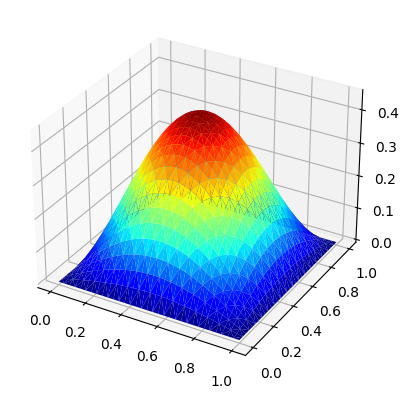

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

#Please choose the eige_index from 0 to 8.
eig_index=0

nodes = mesh.coordinates()
x = nodes[:,0]
y = nodes[:,1]

u = Function(V)
u.vector()[:] = eigenvectors[:, eig_index]*(-1)
z = u.compute_vertex_values(mesh)
if u((0.5,0.5))<0:
    z=z*-1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
plt.show()

## Step 6. Lower eigenvalue bounds
    
Calculate  the lower bounds for the leading 9 exact eigenvalues. 

### Notice 
This method only holds for convex domain with homogeneous Dirichlet boundary condition.


In [96]:
Ch=0.493*h;

import numpy as np

exact_eigvalues = np.array([2,5,5,8,10,10,13,13,18])*pi**2;

# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(0,9):
    eig_value = eigenvalues[k]
    exact_eig = exact_eigvalues[k]
    lower_bound = eig_value/(1+Ch*Ch*eig_value)
    # print("The lower bound of %d theigenvalue: %10.5f  < %10.5f  (Difference: %10.5f) < %10.5f "%(k+1, lower_bound, exact_eig, exact_eig - lower_bound, eig_value ))
    print("%d , Lower bound= %10.8f, Exact value=%10.8f, Upper bound= %10.8f  "%(k+1, lower_bound, exact_eig, eig_value ))


1 , Lower bound= 19.69429909, Exact value=19.73920880, Upper bound= 19.78679229  
2 , Lower bound= 48.97649312, Exact value=49.34802201, Upper bound= 49.55252612  
3 , Lower bound= 49.08867090, Exact value=49.34802201, Upper bound= 49.66736125  
4 , Lower bound= 78.23577939, Exact value=78.95683521, Upper bound= 79.71606372  
5 , Lower bound= 97.33118348, Exact value=98.69604401, Upper bound= 99.63288276  
6 , Lower bound= 97.33617076, Exact value=98.69604401, Upper bound= 99.63810872  
7 , Lower bound= 125.85377193, Exact value=128.30485721, Upper bound= 129.72899928  
8 , Lower bound= 126.77236938, Exact value=128.30485721, Upper bound= 130.70525707  
9 , Lower bound= 163.69445940, Exact value=177.65287922, Upper bound= 170.31162740  


## Part II: Eigenvalue bounds for the L-shaped domain

We apply the method described above to L-shaped domain. Please make sure the `L_uniform.xml` is uploaded to the same folder.

First, let us check the mesh for the L-shaped domain.

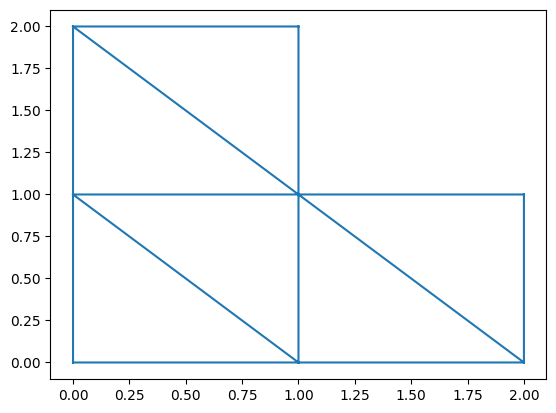

In [97]:
%matplotlib inline

from dolfin import *

import matplotlib.pyplot as plt
import matplotlib.tri as tri

mesh = Mesh("L_uniform.xml")
nodes = mesh.coordinates();
elements = tri.Triangulation(nodes[:, 0], nodes[:, 1], mesh.cells());
plt.triplot(elements)

### Step 1: Upper eigenvalue bounds by using conforming FEM

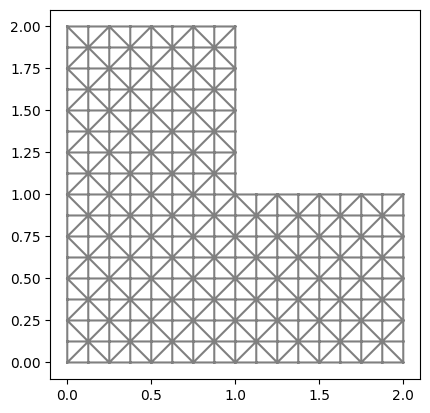

In [98]:
RefineN=3; 
h0=np.sqrt(2);

mesh = Mesh("L_uniform.xml")
for k in range(0,RefineN):
    mesh = refine(mesh)
    h = h/2

plot(mesh)
V = FunctionSpace(mesh, "CG", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)


# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)

# set the diagonal elements of B corresponding to boundary nodes to zero to
# remove spurious eigenvalues.
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

eigenvalues_CG, eigenvectors = scipy_get_leading_eigenvalues(MatA, MatB, 9)

Computation result

In [99]:
import numpy as np

upper_bound_list=[]
# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(0,9):
    eig_value = eigenvalues_CG[k]
    upper_bound_list.append(eig_value)
    print("The %dth approximate eigenvalues (upper bound) :%8.3f "%(k+1, eig_value))

The 1th approximate eigenvalues (upper bound) :   9.923 
The 2th approximate eigenvalues (upper bound) :  15.545 
The 3th approximate eigenvalues (upper bound) :  20.422 
The 4th approximate eigenvalues (upper bound) :  30.898 
The 5th approximate eigenvalues (upper bound) :  33.880 
The 6th approximate eigenvalues (upper bound) :  44.122 
The 7th approximate eigenvalues (upper bound) :  47.609 
The 8th approximate eigenvalues (upper bound) :  53.088 
The 9th approximate eigenvalues (upper bound) :  53.088 


### Step 2: Lower eigenvalue bounds by using the Crouzeix-Raviart FEM

A lower bound for the $k$ eigenvalue is given by [Liu,AMC'2015]:
$$
\lambda_k \ge \frac{\lambda_{k,h}}{1+(0.1893h)^2 \lambda_{k,h}} , \quad (k=1,\cdots, \text{dim}(V_h))
$$
Here, $h$ is the largest edge length over all triangular elements.

**Note** This result works for poygonal domain of arbitrary shapes.


In [100]:
V = FunctionSpace(mesh, "CR", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)


# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)

# set the diagonal elements of B corresponding to boundary nodes to zero to
# remove spurious eigenvalues.
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

eigenvalues_CR, eigenvectors = scipy_get_leading_eigenvalues(MatA, MatB, 9)

In [101]:
Ch=0.1893*h;

lower_bound_list=[]
import numpy as np
for k in range(0,9):
    eig_value = eigenvalues_CR[k]
    lower_bound = eig_value/(1+Ch*Ch*eig_value)
    lower_bound_list.append(lower_bound)
    print("The lower bound of %d theigenvalue: %10.5f"%(k+1, lower_bound))
    

The lower bound of 1 theigenvalue:    9.46115
The lower bound of 2 theigenvalue:   15.10958
The lower bound of 3 theigenvalue:   19.65429
The lower bound of 4 theigenvalue:   29.18237
The lower bound of 5 theigenvalue:   31.11749
The lower bound of 6 theigenvalue:   40.21320
The lower bound of 7 theigenvalue:   43.69776
The lower bound of 8 theigenvalue:   48.24267
The lower bound of 9 theigenvalue:   48.24267


### List of both lower and upper bounds:

In [102]:
import numpy as np

# Extract the leading eigenpair from the smallest eigenvalue.
for k in range(0,9):
    print("%8.6f <= Lambda_%d <= %8.6f "%(lower_bound_list[k], k+1, upper_bound_list[k]))

9.461148 <= Lambda_1 <= 9.923001 
15.109580 <= Lambda_2 <= 15.545167 
19.654293 <= Lambda_3 <= 20.421502 
29.182366 <= Lambda_4 <= 30.897964 
31.117491 <= Lambda_5 <= 33.879531 
40.213198 <= Lambda_6 <= 44.121651 
43.697762 <= Lambda_7 <= 47.609370 
48.242669 <= Lambda_8 <= 53.087666 
48.242669 <= Lambda_9 <= 53.087666 
